<a href="https://colab.research.google.com/github/urvog/weatherclassification/blob/main/WeatherClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather Classification

Project: Weather Image Classifer

## 01 - Importing Weather Data Set

Multi-class weather dataset(MWD) for image classification is a valuable dataset used in the research paper entitled “Multi-class weather recognition from still image using heterogeneous ensemble method”. The dataset provides a platform for outdoor weather analysis by extracting various features for recognizing different weather conditions. 

URL:
https://www.kaggle.com/mauricioarancibia/weatherimgclass/download

Steps: 

- Upload arhive.zip file to colab.
- Unzip archive.zip

In [9]:
COLAB = True

In [10]:
#unziping image files
!unzip archive.zip

Archive:  dataset2.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/cloudy/
  inflating: dataset/test/cloudy/cloudy01.jpg  
  inflating: dataset/test/cloudy/cloudy02.jpg  
  inflating: dataset/test/cloudy/cloudy03.jpg  
  inflating: dataset/test/cloudy/cloudy04.jpg  
  inflating: dataset/test/cloudy/cloudy05.jpg  
  inflating: dataset/test/cloudy/cloudy06.jpg  
  inflating: dataset/test/cloudy/cloudy07.jpg  
  inflating: dataset/test/cloudy/cloudy08.jpg  
  inflating: dataset/test/cloudy/cloudy09.jpg  
  inflating: dataset/test/cloudy/cloudy10.jpg  
  inflating: dataset/test/cloudy/cloudy11.jpg  
  inflating: dataset/test/cloudy/cloudy12.jpg  
  inflating: dataset/test/cloudy/cloudy13.jpg  
   creating: dataset/test/fogsmog/
  inflating: dataset/test/fogsmog/fogsmog001.jpg  
  inflating: dataset/test/fogsmog/fogsmog002.jpg  
  inflating: dataset/test/fogsmog/fogsmog003.jpg  
  inflating: dataset/test/fogsmog/fogsmog004.jpg  
  inflating: dataset/test/fogsm

In [11]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.client import device_lib
from keras.utils.vis_utils import model_to_dot


from IPython.display import SVG
from PIL import Image
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18360888859609993741
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3180871226209766119
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

## 02 - Data Exploration Analysis (EDA)

In this section we will proceed to perform the exploration and analysis of the data.

First, we will proceed to review the structure of the dataset and show some examples of images.


In [12]:
#Lets count all files and show subdirectory structure
totalFiles = 0
totalDir = 0
PATH = 'dataset'

for base, dirs, files in os.walk(PATH):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  dataset
Searching in :  dataset/validation
Searching in :  dataset/validation/cloudy
Searching in :  dataset/validation/snow
Searching in :  dataset/validation/shine
Searching in :  dataset/validation/sunrise
Searching in :  dataset/validation/fogsmog
Searching in :  dataset/validation/rain
Searching in :  dataset/training
Searching in :  dataset/training/cloudy
Searching in :  dataset/training/snow
Searching in :  dataset/training/shine
Searching in :  dataset/training/sunrise
Searching in :  dataset/training/fogsmog
Searching in :  dataset/training/rain
Searching in :  dataset/test
Searching in :  dataset/test/cloudy
Searching in :  dataset/test/snow
Searching in :  dataset/test/shine
Searching in :  dataset/test/sunrise
Searching in :  dataset/test/fogsmog
Searching in :  dataset/test/rain
Total number of files 3348
Total Number of directories 21
Total: 3369


The dataset is composed of images for training, validation and test. The test samples will be used for the final evaluation of the model.

Each subfolder in turn is made up of weather type samples such as: cloudy, shine, sunrise, rain, which are the targets for our ML model.

We have 1125 images samples, and now we will dataset distribution



In [13]:
#Count images samples for each category.

targets = ['cloudy','rain','shine','sunrise','fogsmog','snow']

def count_targets(path_dataset, targets = targets):
  """
  Function to count samples for each category
  input: 
    path_to_dataset - (example, validation, training or test)
    targets - targets from dataset for each category
  output:
    count_target - numpy array with count files for each category
  
  """
  counts_target = []
  for folder in targets:
    path, dirs, files = next(os.walk(path_dataset+folder))
    file_count = len(files)    
    counts_target.append([folder,file_count])
    
  return np.array(counts_target, dtype = object)

train_samples = count_targets(path_dataset = 'dataset/training/')
validation_samples = count_targets(path_dataset = 'dataset/validation/')
test_samples = count_targets(path_dataset = 'dataset/test/')


Text(0.5, 1.0, 'Training Samples')

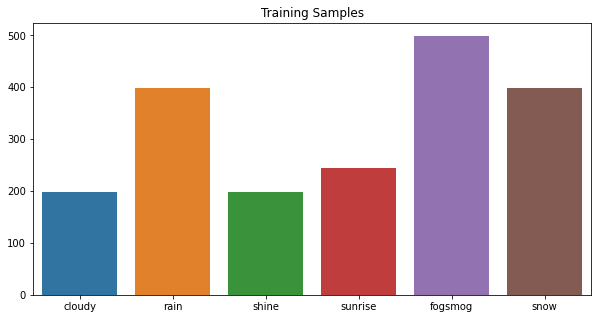

In [14]:
#Let's plot samples distribution for training
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = train_samples[:,0], y = train_samples[:,1])
ax.set_title("Training Samples")

Text(0.5, 1.0, 'Validation Samples')

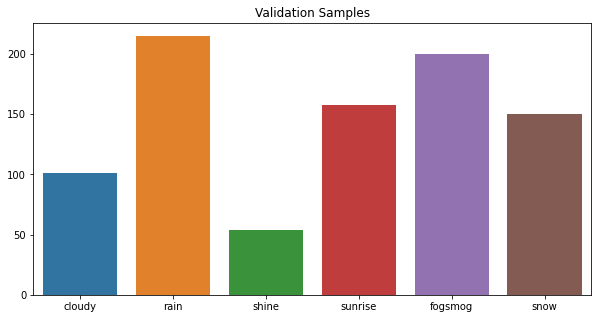

In [15]:
#Let's plot samples distribution for validation
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = train_samples[:,0], y = validation_samples[:,1])
ax.set_title("Validation Samples")

Text(0.5, 1.0, 'Test Samples')

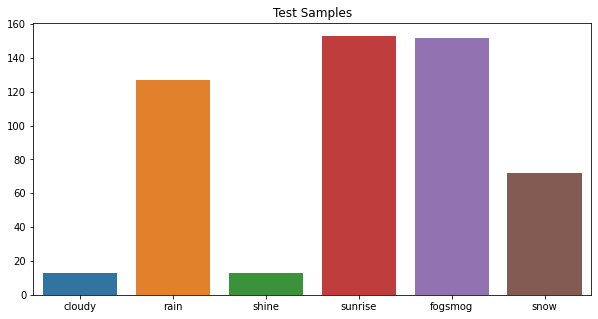

In [16]:
#Let's plot samples distribution for testing
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(x = test_samples[:,0], y = test_samples[:,1])
ax.set_title("Test Samples")

### Images samples

Now we will proceed to show some training samples of the images to see some features


(255, 170)


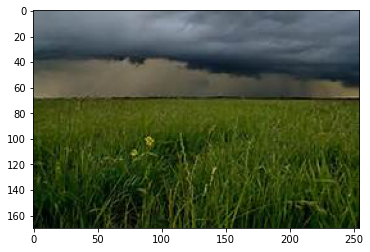

In [17]:
#cloudy
img = Image.open("dataset/training/cloudy/cloudy100.jpg")
print(img.size)
plt.imshow(img)

(1028, 735)


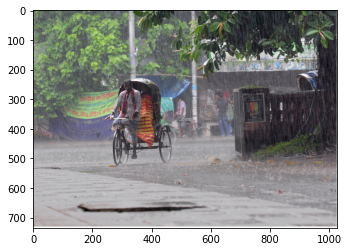

In [18]:
#rain
img = Image.open("dataset/training/rain/rain107.jpg")
print(img.size)
plt.imshow(img)

(235, 178)


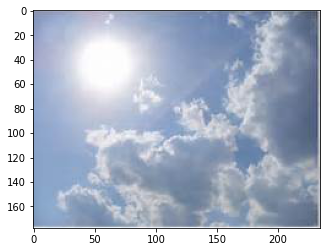

In [19]:
#shine
img = Image.open("dataset/training/shine/shine110.jpg")
print(img.size)
plt.imshow(img)

(245, 163)


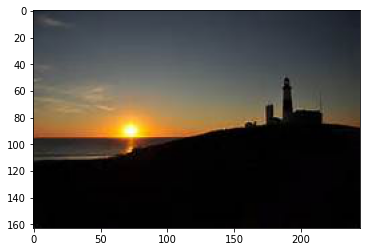

In [20]:
#sunrise
img = Image.open("dataset/validation/sunrise/sunrise048.jpg")
print(img.size)
plt.imshow(img)

(800, 552)


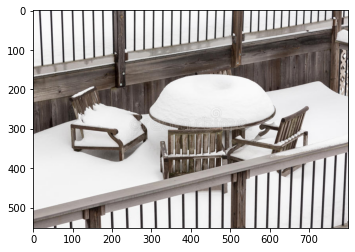

In [21]:
#snow
img = Image.open("dataset/validation/snow/snow102.jpg")
print(img.size)
plt.imshow(img)

(400, 268)


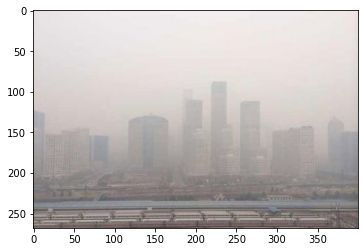

In [22]:
#fogsmog
img = Image.open("dataset/test/fogsmog/fogsmog015.jpg")
print(img.size)
plt.imshow(img)

## 03 - Image Processing anda Data Augmentation

At this stage we are going to generate images using Keras Generator and then save it in a temporary directory "preview/", in this way we can see how the Data Augmentation strategy is working. We disable rescaling so that images can be easily viewed.

In [23]:
!mkdir preview/
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('dataset/training/rain/rain104.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='rain', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

Now it's time to load the dataset with the image generator from Keras. We will use the following configurations: rescaling, rotation, shear range, zoom and horizontal flip.

In [24]:
BATCH_SIZE = 32
IMAGE_SIZE = 150

# this is the augmentation configuration we will use just for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only for rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only for rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset/training/',  # this is the target directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 150x150
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        'dataset/validation/', #this is the validation directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# this is a similar generator, for test data
test_generator = validation_datagen.flow_from_directory(
        'dataset/test/', #this is the validation directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1940 images belonging to 6 classes.
Found 878 images belonging to 6 classes.
Found 530 images belonging to 6 classes.


As shown above, the generators are effectively loaded with the number of samples and categories (targets) identified.

## 04 - Model Implementation

We are now ready to define our model. The strategy for this work is to make two models from scratch and one using transfer learning, in this way we can see the behavior and performance of each one.

### Model 1 Architecture

The one-block model has two single convolutional layer with 32, 16 filters followed by a max pooling layer.

In [25]:
keras.backend.clear_session() #clear model numbers

input_layer = keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

#CNN - Convolutional Layers - Block1
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

#FC - Fully connected
flatten = keras.layers.Flatten()(pooling_layer)
dense = keras.layers.Dense(200, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(dense)

classifier = keras.layers.Dense(6, activation="softmax")(dropout)

model = keras.Model(inputs=input_layer, outputs=classifier)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense (Dense)               (None, 200)               18000200  
                                                             

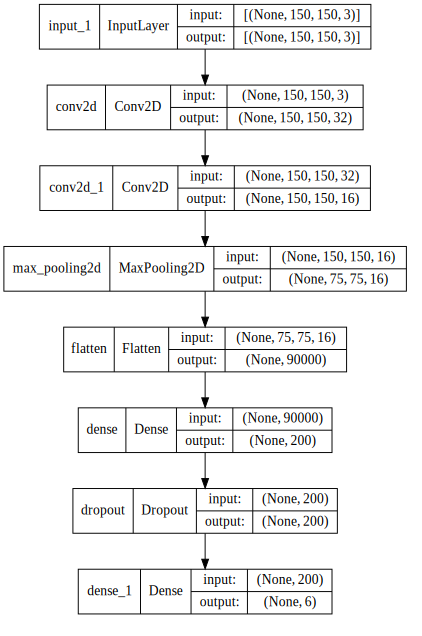

In [26]:
#display model
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=70).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

Visual Simple Model Architecture

     |████████████████████████████████| 795 kB 12.4 MB/s 


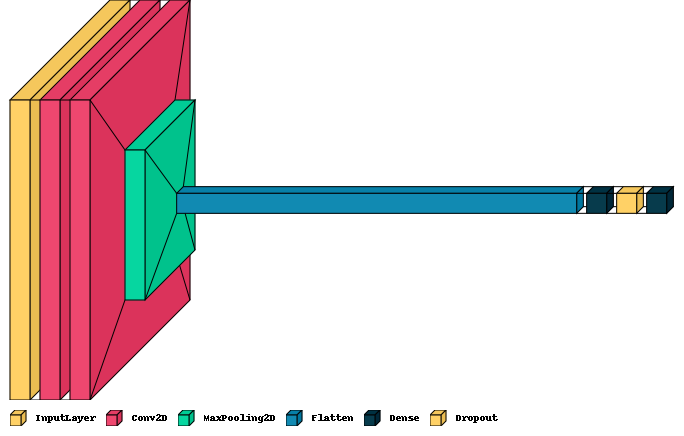

In [27]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, legend=True,scale_xy=2)

### Model 2 Architecture
The two-block model has two convolutional blocks, each block followed by a max pooling layer.

In [28]:
keras.backend.clear_session() #clear model numbers

input_layer = keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

#CNN - Convolutional Layers
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(pooling_layer)
conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

#FC - Fully connected
flatten = keras.layers.Flatten()(pooling_layer)
dense = keras.layers.Dense(200, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(dense)
dense = keras.layers.Dense(100, activation="relu")(dropout)
dropout = keras.layers.Dropout(0.2)(dense)

classifier = keras.layers.Dense(6, activation="softmax")(dropout)

model2 = keras.Model(inputs=input_layer, outputs=classifier)
opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                                                             

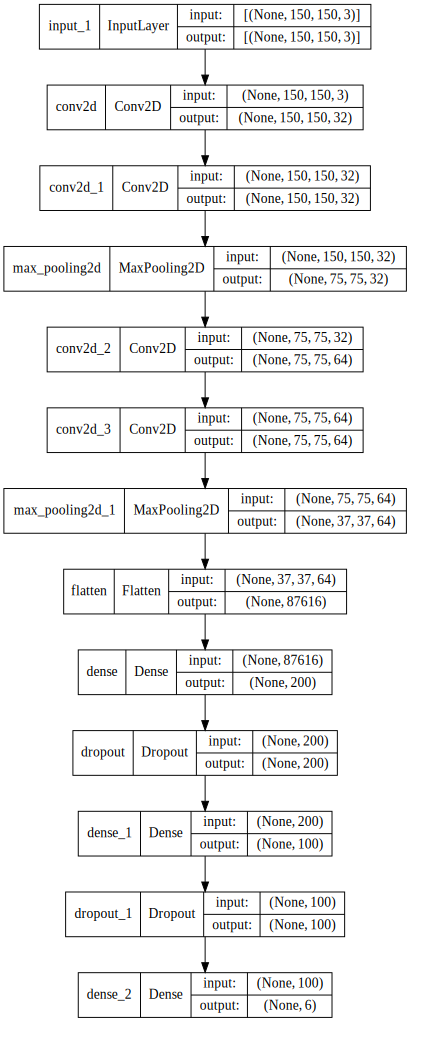

In [29]:
if COLAB:
    display(SVG(model_to_dot(model2, show_shapes=True,dpi=70).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model2, show_shapes=True).create(prog='dot', format='svg')))

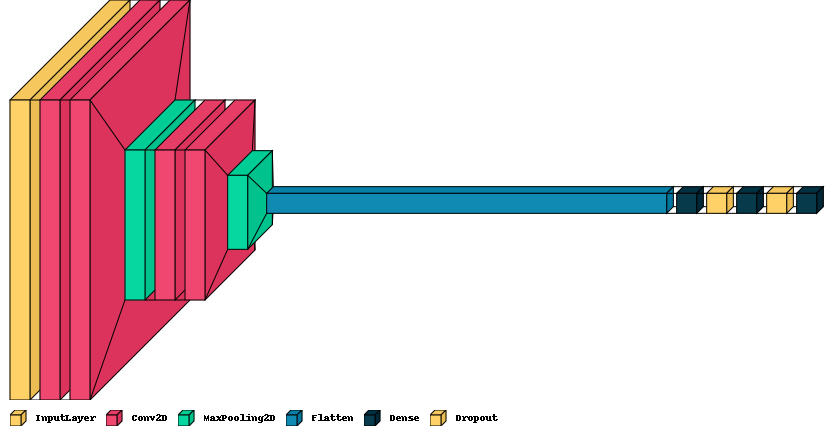

In [30]:
visualkeras.layered_view(model2).show() # display using your system viewer
visualkeras.layered_view(model2, legend=True,scale_xy=2)

## 05 - Training Model

Our two models from scratch are already prepared for Training, we will proced with 50 epochs for each one.

### Training Model 1

In [31]:
history1 = model.fit(train_generator,validation_data=validation_generator, epochs=50)

Epoch 1/50
61/61 [==============================] - 40s 468ms/step - loss: 2.6660 - accuracy: 0.4778 - val_loss: 1.1532 - val_accuracy: 0.5774
Epoch 2/50
61/61 [==============================] - 24s 395ms/step - loss: 1.0548 - accuracy: 0.5851 - val_loss: 0.9202 - val_accuracy: 0.6879
Epoch 3/50
61/61 [==============================] - 24s 400ms/step - loss: 0.9508 - accuracy: 0.6211 - val_loss: 0.8120 - val_accuracy: 0.7141
Epoch 4/50
61/61 [==============================] - 27s 438ms/step - loss: 0.8805 - accuracy: 0.6510 - val_loss: 0.7995 - val_accuracy: 0.7255
Epoch 5/50
61/61 [==============================] - 24s 399ms/step - loss: 0.8190 - accuracy: 0.6902 - val_loss: 0.8771 - val_accuracy: 0.7062
Epoch 6/50
61/61 [==============================] - 24s 398ms/step - loss: 0.8455 - accuracy: 0.6758 - val_loss: 0.6821 - val_accuracy: 0.7620
Epoch 7/50
61/61 [==============================] - 24s 397ms/step - loss: 0.7780 - accuracy: 0.7062 - val_loss: 0.6325 - val_accuracy: 0.7768

### Training Model 2

In [32]:
history2 = model2.fit(train_generator,validation_data=validation_generator, epochs=50)

Epoch 1/50
61/61 [==============================] - 25s 401ms/step - loss: 1.4013 - accuracy: 0.4485 - val_loss: 0.8991 - val_accuracy: 0.6891
Epoch 2/50
61/61 [==============================] - 24s 396ms/step - loss: 0.9956 - accuracy: 0.6309 - val_loss: 0.8195 - val_accuracy: 0.6731
Epoch 3/50
61/61 [==============================] - 24s 399ms/step - loss: 0.8636 - accuracy: 0.6948 - val_loss: 0.7667 - val_accuracy: 0.7415
Epoch 4/50
61/61 [==============================] - 24s 402ms/step - loss: 0.8081 - accuracy: 0.6969 - val_loss: 0.7686 - val_accuracy: 0.7153
Epoch 5/50
61/61 [==============================] - 24s 399ms/step - loss: 0.7669 - accuracy: 0.7144 - val_loss: 0.5981 - val_accuracy: 0.7733
Epoch 6/50
61/61 [==============================] - 24s 399ms/step - loss: 0.7609 - accuracy: 0.7134 - val_loss: 0.7293 - val_accuracy: 0.7164
Epoch 7/50
61/61 [==============================] - 24s 400ms/step - loss: 0.6847 - accuracy: 0.7510 - val_loss: 0.7866 - val_accuracy: 0.7323

## 06 - Loss and Accuracy Plotting

In [33]:
import matplotlib.pyplot as plt
def plot_curves(history):
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['Training', 'Validation'])

  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.legend(['Training', 'Validation'], loc='lower right');

### Plotting Model Performance 1

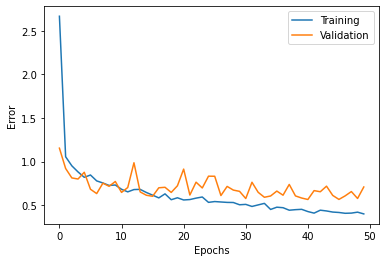

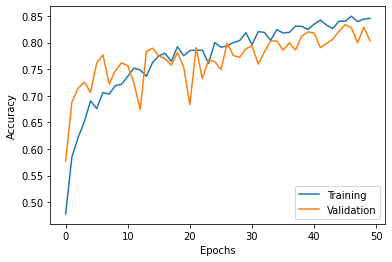

In [34]:
plot_curves(history1.history)

### Plotting Model Performance 2

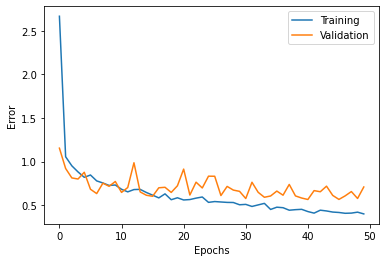

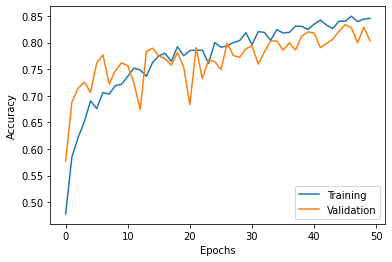

In [35]:
plot_curves(history1.history)

## 07 - Preliminar Scores (Training & Validation)

### Scores Model 1

In [43]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_tr = model.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

61/61 [==============================] - 22s 351ms/step - loss: 0.2889 - accuracy: 0.8876
Train loss    : 0.28892555832862854
Train accuracy: 0.8876288533210754
28/28 [==============================] - 3s 119ms/step - loss: 0.7080 - accuracy: 0.8030
Val loss    : 0.7080493569374084
Val accuracy: 0.8029612898826599
17/17 [==============================] - 2s 105ms/step - loss: 0.6226 - accuracy: 0.8226
Test loss    : 0.6225793361663818
Test accuracy: 0.8226414918899536


### Scores Model 2

In [44]:
scores_tr = model2.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model2.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_tr = model2.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

61/61 [==============================] - 26s 420ms/step - loss: 0.2517 - accuracy: 0.8979
Train loss    : 0.2516500949859619
Train accuracy: 0.8979381322860718
28/28 [==============================] - 3s 119ms/step - loss: 0.6954 - accuracy: 0.8178
Val loss    : 0.6953643560409546
Val accuracy: 0.8177676796913147
17/17 [==============================] - 2s 110ms/step - loss: 0.5308 - accuracy: 0.8472
Test loss    : 0.5308366417884827
Test accuracy: 0.847169816493988


## 08 - Predictions

In [38]:
#print classes indices
print(train_generator.class_indices)

{'cloudy': 0, 'fogsmog': 1, 'rain': 2, 'shine': 3, 'snow': 4, 'sunrise': 5}


In [ ]:
def plot_predictions(model):
  fig = plt.figure(figsize=(20, 7))
  rows = 6
  columns = 2
  c = 1
  for i in range(0,4):
    for j in range(0,2):
      idx_img = np.random.randint(1,10)
      if i == 0:
        path = 'dataset/validation/cloudy/cloudy0'+str(idx_img)+'.jpg'
      elif i == 1:
        path ='dataset/validation/fogsmog/fogsmod'+str(idx_img)+'.jpg'
      elif i == 2:
        path ='dataset/validation/rain/rain'+str(idx_img)+'.jpg'
      elif i == 3:
        path ='dataset/validation/shine/sunshine'+str(idx_img)+'.jpg'
      elif i == 4:
        path ='dataset/validation/snow/snow'+str(idx_img)+'.jpg'
      elif i == 5:
        path ='dataset/validation/sunrise/sunrise'+str(idx_img)+'.jpg'

      fig.add_subplot(rows,columns,c)
      img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
      x=img_to_array(img)
      x=np.expand_dims(x, axis=0)
      images = np.vstack([x])
      classes = model.predict(images)
      str_predict = "Cloudy: {:.2f}%, Fogsmog: {:.2f}%, Rain: {:.2f}%, Shine: {:.2f}%, Snow: {} ".format(classes[0][0]*100,classes[0][1]*100,classes[0][2]*100, classes[0][3]*100)
      plt.imshow(img)
      plt.axis('off')
      plt.title(str_predict)
      c+=1

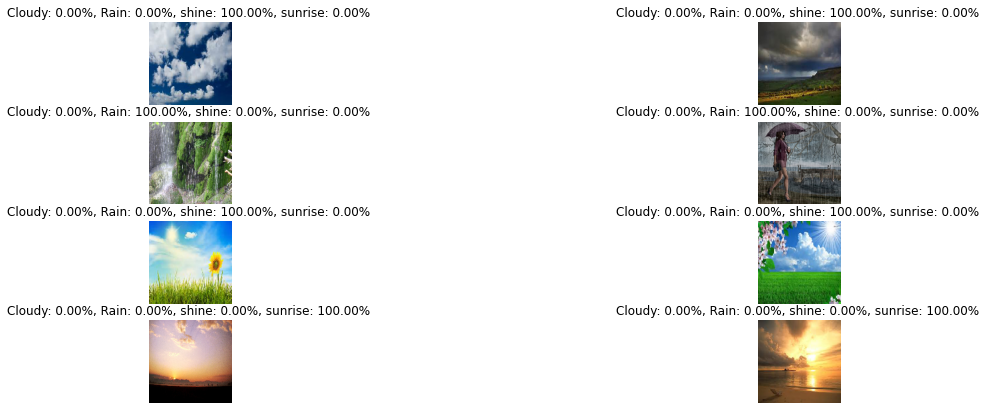

In [ ]:
plot_predictions(model2)

## 09 - Transfer Learning Model

### Importing Pretrained Model (VGG16)

In [45]:
#importing VGG16 model, weights and freeze
from tensorflow.keras.applications import VGG16
vgg16_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # drop the Dense layers!
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
print(vgg16_base.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### Implementing transfer model

In [53]:
keras.backend.clear_session() #clear model numbers

for layer in vgg16_base.layers:
    layer.trainable = False
    
model_t = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg16_base,
        # here is our custom prediction layer (same as before)
        keras.layers.Flatten(),    
        keras.layers.Dense(512, activation='relu'),           
        keras.layers.Dropout(0.5),                 
        keras.layers.Dense(256, activation='relu'),           
        keras.layers.Dense(6, activation='softmax')    
    ])

model_t.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_t.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 19,042,374
Trainable params: 4,327,686
Non

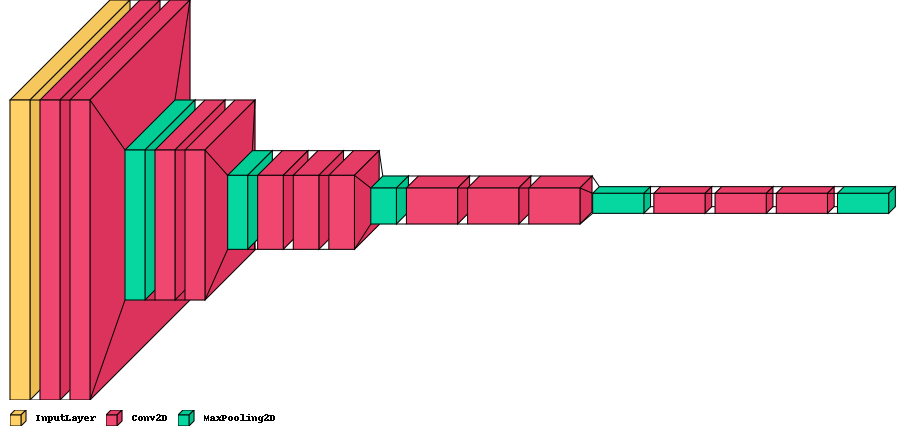

In [41]:
visualkeras.layered_view(vgg16_base).show() # display vgg16 model architecture
visualkeras.layered_view(vgg16_base, legend=True,scale_xy=2)

### Training Transfer Model

In [ ]:
#training
history3 = model_t.fit(train_generator,validation_data=validation_generator, epochs=50)

Epoch 1/50
61/61 [==============================] - 26s 414ms/step - loss: 1.0927 - accuracy: 0.5918 - val_loss: 0.6605 - val_accuracy: 0.7745
Epoch 2/50
61/61 [==============================] - 25s 415ms/step - loss: 0.6779 - accuracy: 0.7469 - val_loss: 0.6160 - val_accuracy: 0.7938
Epoch 3/50
61/61 [==============================] - 28s 455ms/step - loss: 0.6130 - accuracy: 0.7825 - val_loss: 0.5215 - val_accuracy: 0.8144
Epoch 4/50
61/61 [==============================] - 26s 416ms/step - loss: 0.5432 - accuracy: 0.7907 - val_loss: 0.4877 - val_accuracy: 0.8360
Epoch 5/50
61/61 [==============================] - 25s 413ms/step - loss: 0.5149 - accuracy: 0.8155 - val_loss: 0.4651 - val_accuracy: 0.8405
Epoch 6/50
61/61 [==============================] - 25s 414ms/step - loss: 0.4599 - accuracy: 0.8345 - val_loss: 0.4992 - val_accuracy: 0.8212
Epoch 7/50
61/61 [==============================] - 25s 404ms/step - loss: 0.4544 - accuracy: 0.8423 - val_loss: 0.5450 - val_accuracy: 0.8007

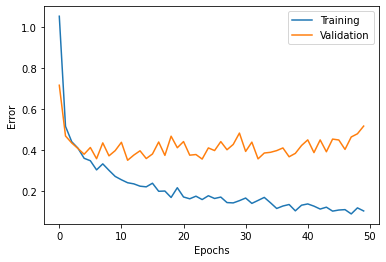

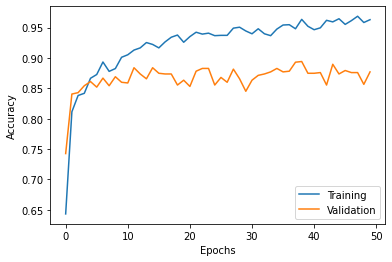

In [ ]:
plot_curves(history3.history)

In [ ]:
scores_tr = model_t.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model_t.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

61/61 [==============================] - 23s 365ms/step - loss: 0.0650 - accuracy: 0.9768
Train loss    : 0.06503433734178543
Train accuracy: 0.9768041372299194
28/28 [==============================] - 4s 134ms/step - loss: 0.5182 - accuracy: 0.8770
Val loss    : 0.5181561708450317
Val accuracy: 0.8769931793212891


## 10 - Final Scores (Test)

Finally, it is time to compare the three models with the test dataset to see how well our model generalizes.



In [ ]:
#model1
scores_tr = model.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

#model2
scores_tr = model2.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

#model with transfer learning
scores_tr = model_t.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])



17/17 [==============================] - 2s 101ms/step - loss: 0.7581 - accuracy: 0.7962
Test loss    : 0.758113443851471
Test accuracy: 0.796226441860199
17/17 [==============================] - 2s 106ms/step - loss: 0.8732 - accuracy: 0.7849
Test loss    : 0.8731572031974792
Test accuracy: 0.7849056720733643
17/17 [==============================] - 2s 115ms/step - loss: 0.5808 - accuracy: 0.8698
Test loss    : 0.580842137336731
Test accuracy: 0.8698112964630127


## 11 - Conclusions